In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd

In [2]:
dataset='NKG2' # note MICs and VAN are formatted differently

micapipe_dir = f'/data/mica3/BIDS_{dataset}/derivatives/micapipe_v0.2.0'
hippunfold_dir = f'/data/mica3/BIDS_{dataset}/derivatives/hippunfold_v1.3.0/hippunfold'

hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den = '0p5mm'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# loop through these types of structural images
features = ['thickness','gyrification','curvature','surfarea']

In [3]:
PX = pd.read_csv(f'/host/percy/local_raid/judy/brainz/zbrains_csvs/participants_{dataset}_px.csv', delimiter=',')
PX

,ID,SES,SITE,group,pathology,AGE,SEX,T1W,DWI
0,sub-PX001,ses-pre,NKG2,Patient,Left TLE,16,M,1,1
1,sub-PX002,ses-pre,NKG2,Patient,Left TLE,23,M,1,1
2,sub-PX003,ses-pre,NKG2,Patient,Left TLE,18,M,1,1
3,sub-PX004,ses-pre,NKG2,Patient,Left TLE,20,F,1,1
4,sub-PX005,ses-pre,NKG2,Patient,Left TLE,23,M,1,1
5,sub-PX006,ses-pre,NKG2,Patient,Left TLE,17,M,1,1
6,sub-PX007,ses-pre,NKG2,Patient,Left TLE,33,M,1,1
7,sub-PX008,ses-pre,NKG2,Patient,Left TLE,48,M,1,1
8,sub-PX009,ses-pre,NKG2,Patient,Left TLE,39,F,1,1
9,sub-PX010,ses-pre,NKG2,Patient,Left TLE,32,F,1,1


In [4]:
# Load data
hipp_dat = np.zeros([nV,len(hemis),len(PX['ID']),len(features)])*np.nan 

# Preprocess
# Profile align the depths of each column (as in https://github.com/jordandekraker/hippomaps/blob/master/tutorials/Histology-MRI-9p4T.ipynb)
for f,feature in enumerate(features):
    for s,sub in enumerate(PX['ID']):
        for h,hemi in enumerate(hemis):  
            for l,label in enumerate(labels):
                ses = PX['SES'][s]
                if PX['pathology'][s][0] == hemi:
                    ic = 0 # always put ipsi first
                else:
                    ic=1 # contra second
                fn = f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_{feature}.shape.gii'
                if feature=='curvature' and hemi == 'R':
                    hipp_dat[iV[l],ic,s,f] = -nib.load(fn).darrays[0].data
                else:
                    hipp_dat[iV[l],ic,s,f] = nib.load(fn).darrays[0].data

In [5]:
coolumnar_volume = hipp_dat[:,:,:,0]*hipp_dat[:,:,:,3]
hipp_dat = np.concatenate((hipp_dat,coolumnar_volume.reshape([nV,len(hemis),len(PX['ID']),1])),axis=3)
features.append('columnarVol')

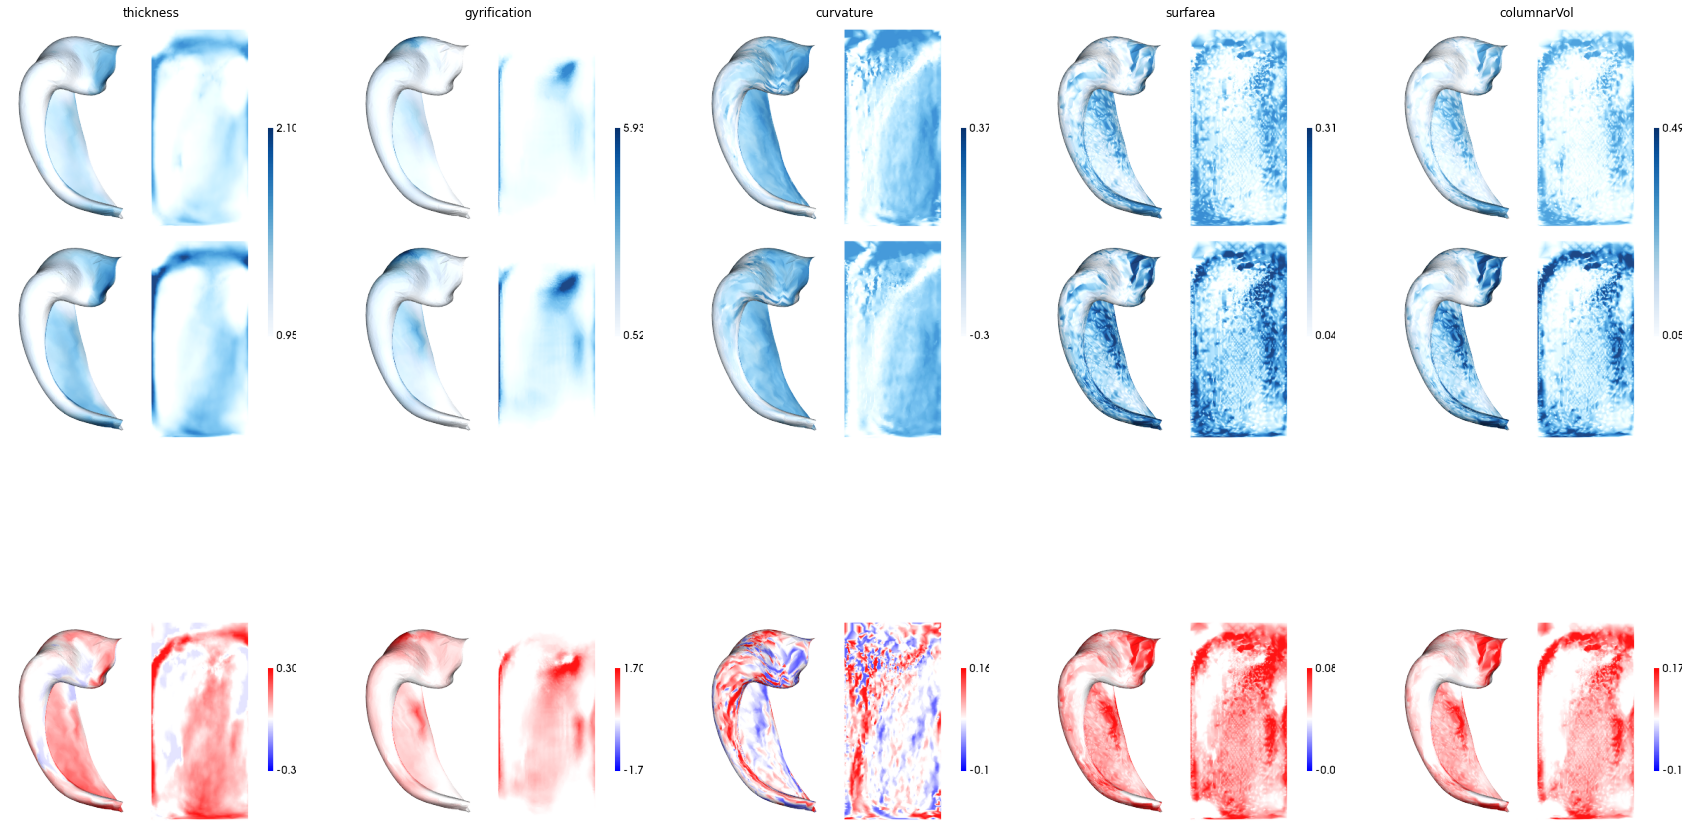

In [6]:
ipsilateral = np.mean(hipp_dat[:,0,:,:], axis=1)
contralateral = np.mean(hipp_dat[:,1,:,:], axis=1)
asymmetry = np.mean(hipp_dat[:,1,:,:]-hipp_dat[:,0,:,:], axis=1)

cdata = np.stack((ipsilateral,contralateral,asymmetry),axis=2)

fig, ax = plt.subplots(2,5, figsize=(30,20))
for f in range(5):
    hm.plotting.surfplot_canonical_foldunfold(cdata[:,f,:2], color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='Blues', color_range='sym', unfoldAPrescale=True, share='both', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    i = plt.imread('tmp.png')
    ax[0,f].imshow(i)
    ax[0,f].set_axis_off()
    ax[0,f].set_anchor("NW")
    ax[0,f].set_title(features[f])
    hm.plotting.surfplot_canonical_foldunfold(cdata[:,f,2], color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='bwr', color_range='sym', unfoldAPrescale=True, share='both', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    i = plt.imread('tmp.png')
    ax[1,f].imshow(i)
    ax[1,f].set_axis_off()
    ax[1,f].set_anchor("NW")
    
!rm tmp.png

Ttest_1sampResult(statistic=12.961341341123504, pvalue=6.65589122234726e-28)
Ttest_1sampResult(statistic=12.255135275829238, pvalue=8.633657033751425e-26)
Ttest_1sampResult(statistic=0.29855939914343244, pvalue=0.7656042422728271)
Ttest_1sampResult(statistic=12.154361773794673, pvalue=1.7253256489399945e-25)
Ttest_1sampResult(statistic=14.522948209050066, pvalue=1.379234559408456e-32)


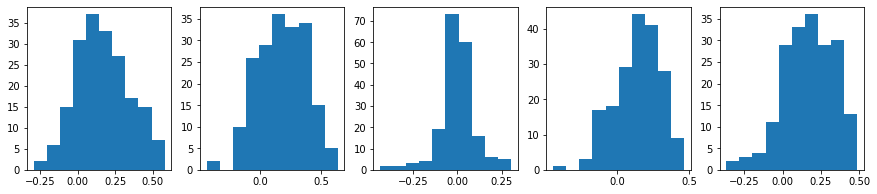

In [7]:
from scipy.stats import ttest_1samp

# now repeat for all features and make a histogram of the off-diagonal values
mfcorr = []
sdfcorr = []
fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(3*len(features),3))
for f,feature in enumerate(features):
    cdat = hipp_dat[:,1,:,f]-hipp_dat[:,0,:,f]
    corr = np.corrcoef(cdat.T) # as above 2
    fcorr = corr[np.triu_indices(20,k=1)] # this return only the off-diagonal (lower left triangle)
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr) # make a histogram for this particular feature
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

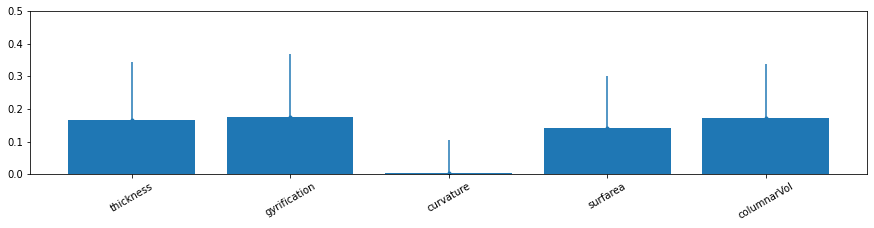

In [8]:
# instead of histograms, we will show a bar plot of the average and standard deviation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(features),3))
plt.bar(range(len(features)),mfcorr)
plt.errorbar(range(len(features)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(features)),labels=features,rotation=30)
plt.ylim([0,.5]);

[['MRI-7T-thickness' 'histology-thickness' 'iEEG-BandPower-beta']
 ['MRI-7T-gyrification' 'histology-gyrification' 'iEEG-BandPower-gamma']
 ['histology-Parvalbumin' 'histology-Bieloschowsky' 'histology-Blockface']
 ['MRI-7T-thickness' 'histology-thickness' 'histology-Calretinin']
 ['MRI-7T-thickness' 'histology-thickness' 'histology-Blockface']]
[[ 0.46715829  0.31681421  0.29454311]
 [ 0.70618678  0.62309191 -0.32295803]
 [-0.04799485 -0.03788342  0.03388453]
 [ 0.27615735  0.22858541 -0.21474381]
 [ 0.43211052  0.25399381  0.19984269]]
[[0.    0.001 0.043]
 [0.    0.    0.132]
 [0.039 0.068 0.08 ]
 [0.001 0.034 0.066]
 [0.    0.001 0.019]]


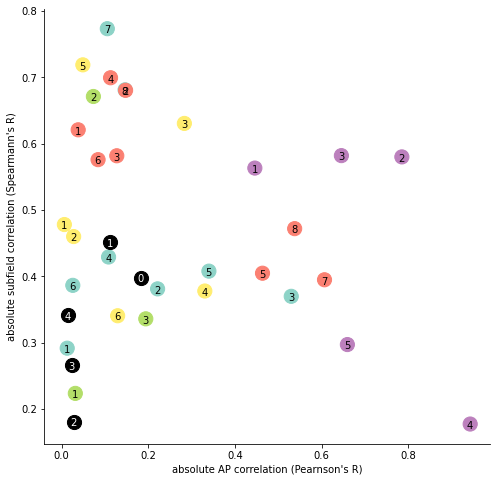

In [9]:
# here we look only at the pattern separation and novelty conditions
topFeatures, topR, topP, APcorr, Subfscorr, ax = hm.stats.contextualize2D(asymmetry, nperm=1000) # ideally nperm should be 10000

print(topFeatures)
print(topR)
print(topP)